# Imports

In [2]:
import pandas
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
from pysal.lib import weights
from pysal.explore import esda
import seaborn
from splot import esda as esdaplot

C:\Users\20211147\PycharmProjects\DataMiningCodes\venv\lib\site-packages\spaghetti\network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


# Data Preparation

In [3]:
# Data loading
gdp_df = pandas.read_csv("data/GDP(Nuts2)/nama_10r_2gdp_linear.csv")
# Choosing a unit - PPS (Purchasing Power Standards) per inhabitant
gdp_df = gdp_df[gdp_df['unit']=='PPS_EU27_2020_HAB']
# Renaming geo column
gdp_df.rename(columns={'geo': 'NUTS_ID'}, inplace=True)
gdp_df.rename(columns={'OBS_VALUE': 'GDP_VALUE'}, inplace=True)
# Removing unnecessary columns (only one value for all rows)
gdp_df = gdp_df.drop(columns=['DATAFLOW','LAST UPDATE','freq', 'unit', 'OBS_FLAG'])
# Convert all values to a specific type (e.g., int)
gdp_df['NUTS_ID'] = gdp_df['NUTS_ID'].astype(object)
gdp_df['TIME_PERIOD'] = gdp_df['TIME_PERIOD'].astype(str)
gdp_df['GDP_VALUE'] = gdp_df['GDP_VALUE'].astype(float)

## ---- Aggregating time series: Choosing MEDIAN among years ----- ##

# First, let's remove outliers from each NUTS_ID group
def remove_outliers(group):
    q1 = group['GDP_VALUE'].quantile(0.25)
    q3 = group['GDP_VALUE'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return group[(group['GDP_VALUE'] >= lower_bound) & (group['GDP_VALUE'] <= upper_bound)]
# Apply the function to each group and concatenate the results
cleaned_df = gdp_df.groupby('NUTS_ID').apply(remove_outliers).reset_index(drop=True)
# Now, let's aggregate the cleaned data by taking the mean for each NUTS_ID
aggregated_df = cleaned_df.groupby('NUTS_ID')['GDP_VALUE'].mean().reset_index()
# Optionally, you can merge the aggregated values back to the original DataFrame
final_df = gdp_df.merge(aggregated_df, on='NUTS_ID', suffixes=('', '_mean'), how='left')

aggregated_df

,NUTS_ID,GDP_VALUE
0,AL,8235.714286
1,AL0,8235.714286
2,AL01,6635.714286
3,AL02,10042.857143
4,AL03,7808.333333
...,...,...
431,TRB2,6052.631579
432,TRC,7826.315789
433,TRC1,9873.684211
434,TRC2,6478.947368


In [4]:
# Reading the shapefile data (ESPG:3035 - projected CRS needed for centroid calculation!)
gdf_3035 = gpd.read_file("data/NUTS_RG_20M_2021_3035.shp/NUTS_RG_20M_2021_3035.shp")
# Reading the shapefile data (ESPG:4326 - GEOGRAPHIC COORDINATE SYSTEM)
gdf_4326 = gpd.read_file("data/NUTS_RG_20M_2021_4326.shp/NUTS_RG_20M_2021_4326.shp")
# Merging gdp_2021 data with shapefile data
merged_df = pandas.merge(aggregated_df, gdf_3035, on='NUTS_ID', how='left')
# Extracting ONLY nuts level 2 regions!
gdp_lvl2_df = merged_df[merged_df['LEVL_CODE']== 2.0]
# Selecting only the required columns
gdp_lvl2 = gdp_lvl2_df[['NUTS_ID', 'NUTS_NAME', 'NAME_LATN', 'GDP_VALUE', 'geometry']].copy()
# Create a GeoDataFrame
gdp_lvl2 = gpd.GeoDataFrame(gdp_lvl2, geometry='geometry')

##-----Centroid Calculation-------##
# Now, calculate the centroids (but float values!)
gdp_lvl2['centroid_lon'] = gdp_lvl2.geometry.centroid.x
gdp_lvl2['centroid_lat'] = gdp_lvl2.geometry.centroid.y
# Create a new geometry column for the centroids
gdp_lvl2['centroid_geometry'] = gdp_lvl2.apply(lambda row: Point(row['centroid_lon'], row['centroid_lat']), axis=1)
# Convert the DataFrame to a GeoDataFrame with the new geometry column
gdf_lvl2 = gpd.GeoDataFrame(gdp_lvl2, geometry='geometry')
# Converting geo df into coordinate system (only for visualizations!)
gdf_lvl2.crs = "EPSG:3035"
gdf_vis = gdf_lvl2.to_crs(epsg=4326)

gdf_lvl2

,NUTS_ID,NUTS_NAME,NAME_LATN,GDP_VALUE,geometry,centroid_lon,centroid_lat,centroid_geometry
2,AL01,Veri,Veri,6635.714286,"POLYGON ((5129579.170 2204098.752, 5148385.473...",5.147918e+06,2.148188e+06,POINT (5147918.319 2148187.981)
3,AL02,Qender,Qender,10042.857143,"POLYGON ((5148777.300 2099959.278, 5178238.968...",5.166092e+06,2.059374e+06,POINT (5166092.179 2059373.925)
4,AL03,Jug,Jug,7808.333333,"POLYGON ((5247352.798 2040320.505, 5257241.465...",5.183507e+06,1.987414e+06,POINT (5183506.850 1987413.628)
7,AT11,Burgenland,Burgenland,22521.739130,"POLYGON ((4846489.857 2803511.391, 4854633.294...",4.811632e+06,2.736034e+06,POINT (4811631.520 2736034.450)
8,AT12,Niederösterreich,Niederösterreich,27095.652174,"POLYGON ((4742889.368 2876362.725, 4783217.798...",4.748503e+06,2.811574e+06,POINT (4748502.704 2811574.162)
...,...,...,...,...,...,...,...,...
430,TRB1,"Malatya, Elazığ, Bingöl, Tunceli","Malatya, Elazığ, Bingöl, Tunceli",9247.368421,"POLYGON ((6874779.807 2348344.184, 6890718.965...",6.810685e+06,2.236288e+06,POINT (6810684.626 2236287.853)
431,TRB2,"Van, Muş, Bitlis, Hakkari","Van, Muş, Bitlis, Hakkari",6052.631579,"POLYGON ((7079743.967 2368049.187, 7090192.978...",7.131402e+06,2.329574e+06,POINT (7131401.745 2329574.128)
433,TRC1,"Gaziantep, Adıyaman, Kilis","Gaziantep, Adıyaman, Kilis",9873.684211,"POLYGON ((6820569.117 2163902.580, 6827627.296...",6.739547e+06,2.038815e+06,POINT (6739547.084 2038815.374)
434,TRC2,"Şanlıurfa, Diyarbakır","Şanlıurfa, Diyarbakır",6478.947368,"POLYGON ((6989716.599 2273670.524, 6982786.486...",6.883662e+06,2.122830e+06,POINT (6883662.278 2122830.246)


In [5]:
# Find the region with maximum GDP
max_gdp_row = gdf_lvl2[gdf_lvl2['GDP_VALUE'] == gdf_lvl2['GDP_VALUE'].max()]
max_region_id = max_gdp_row['NUTS_ID'].values[0]
max_region_name = max_gdp_row['NAME_LATN'].values[0]
max_gdp_value = max_gdp_row['GDP_VALUE'].values[0]

# Find the region with minimum GDP
min_gdp_row = gdf_lvl2[gdf_lvl2['GDP_VALUE'] == gdf_lvl2['GDP_VALUE'].min()]
min_region_id = min_gdp_row['NUTS_ID'].values[0]
min_region_name = min_gdp_row['NAME_LATN'].values[0]
min_gdp_value = min_gdp_row['GDP_VALUE'].values[0]

# Create a DataFrame with the results
result_df = pandas.DataFrame({
    'metric': ['max GDP', 'min GDP'],
    'region_id': [max_region_id, min_region_id],
    'region_name': [max_region_name, min_region_name],
    'GDP_value': [max_gdp_value, min_gdp_value]
})
result_df

,metric,region_id,region_name,GDP_value
0,max GDP,LU00,Luxembourg,68365.217391
1,min GDP,TRB2,"Van, Muş, Bitlis, Hakkari",6052.631579


In [20]:
gdf_lvl2.to_csv("data/GDP_aggregated_data_nuts3.csv")

# Spatial Autocorrelation

In [6]:
# Setting the index to NUTS_ID
gdf_lvl2.set_index('NUTS_ID', inplace=True)

In [7]:
gdf_lvl2

,NUTS_NAME,NAME_LATN,GDP_VALUE,geometry,centroid_lon,centroid_lat,centroid_geometry
NUTS_ID,,,,,,,
AL01,Veri,Veri,6635.714286,"POLYGON ((5129579.170 2204098.752, 5148385.473...",5.147918e+06,2.148188e+06,POINT (5147918.319 2148187.981)
AL02,Qender,Qender,10042.857143,"POLYGON ((5148777.300 2099959.278, 5178238.968...",5.166092e+06,2.059374e+06,POINT (5166092.179 2059373.925)
AL03,Jug,Jug,7808.333333,"POLYGON ((5247352.798 2040320.505, 5257241.465...",5.183507e+06,1.987414e+06,POINT (5183506.850 1987413.628)
AT11,Burgenland,Burgenland,22521.739130,"POLYGON ((4846489.857 2803511.391, 4854633.294...",4.811632e+06,2.736034e+06,POINT (4811631.520 2736034.450)
AT12,Niederösterreich,Niederösterreich,27095.652174,"POLYGON ((4742889.368 2876362.725, 4783217.798...",4.748503e+06,2.811574e+06,POINT (4748502.704 2811574.162)
...,...,...,...,...,...,...,...
TRB1,"Malatya, Elazığ, Bingöl, Tunceli","Malatya, Elazığ, Bingöl, Tunceli",9247.368421,"POLYGON ((6874779.807 2348344.184, 6890718.965...",6.810685e+06,2.236288e+06,POINT (6810684.626 2236287.853)
TRB2,"Van, Muş, Bitlis, Hakkari","Van, Muş, Bitlis, Hakkari",6052.631579,"POLYGON ((7079743.967 2368049.187, 7090192.978...",7.131402e+06,2.329574e+06,POINT (7131401.745 2329574.128)
TRC1,"Gaziantep, Adıyaman, Kilis","Gaziantep, Adıyaman, Kilis",9873.684211,"POLYGON ((6820569.117 2163902.580, 6827627.296...",6.739547e+06,2.038815e+06,POINT (6739547.084 2038815.374)


In [8]:
## Spatial Autocorrelation
#gdf_lvl2 = gdf_lvl2.drop(columns=['centroid_geometry'])
#gdf_lvl2 = gdf_lvl2.set_geometry('geometry')

# Building kernel weights
# Distance weights: Build weights with adaptive bandwidth
w_adaptive = weights.distance.Kernel.from_dataframe(gdf_lvl2, fixed=False, k=15)
# Distance weights: Generate W from the GeoDataFrame
#w_KNN= weights.KNN.from_dataframe(gdf_lvl2, k=5)

# Row-standardization
#w_KNN.transform = "R"
w_adaptive.transform = "R"

# Global SAC
moran = esda.moran.Moran(gdf_lvl2["GDP_VALUE"], w_adaptive)

## - Local SAC (local Moran's I) - ##
# Creating the local moran object
lisa = esda.moran.Moran_Local(gdf_lvl2["GDP_VALUE"], w_adaptive)

In [9]:
print(moran.I)
print(moran.p_sim)

0.63686212878378
0.001


In [10]:
# percentage of lisa values above 0 (positive)
lisa_list = list(lisa.Is)
count_above_zero = sum(1 for value in lisa_list if value > 0)
total_values = len(lisa_list)
percentage = (count_above_zero / total_values) * 100
percentage

85.17241379310346

#### Neighbour number v.s. Moran's I

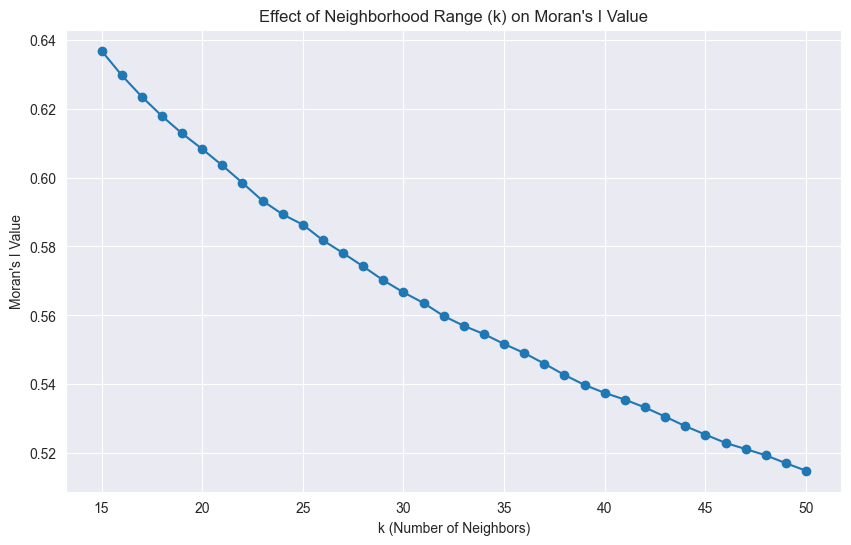

In [11]:
# Define the range of k values you want to test
k_values = range(15, 51)  # Example: testing k from 1 to 50
# Initialize an empty list to store Moran's I values
moran_values = []

# Loop through each k value
for k in k_values:
    # Create the spatial weight matrix for the current k value
    w_adaptive = weights.distance.Kernel.from_dataframe(gdf_lvl2, fixed=False, k=k)
    w_adaptive.transform = "R"
    # Calculate Moran's I value
    moran = esda.moran.Moran(gdf_lvl2["GDP_VALUE"], w_adaptive)
    # Append the Moran's I value to the list
    moran_values.append(moran.I)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, moran_values, marker='o')
plt.title("Effect of Neighborhood Range (k) on Moran's I Value")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Moran's I Value")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Density Diagram of Local Moran Values')

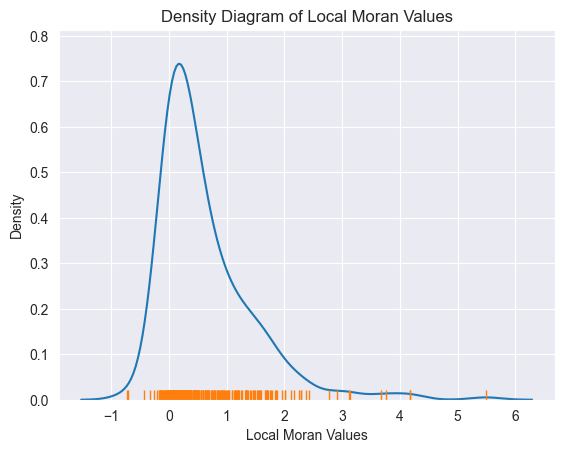

In [12]:
# Visualizing the density diagram of the local moran values (to compare between positive and negative SAC)
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax)
# Add x-axis label
ax.set_xlabel('Local Moran Values')
# Add title
ax.set_title('Density Diagram of Local Moran Values')

In [13]:
# resetting gdf_index before storing new columns
gdf_lvl2.reset_index(inplace=True)

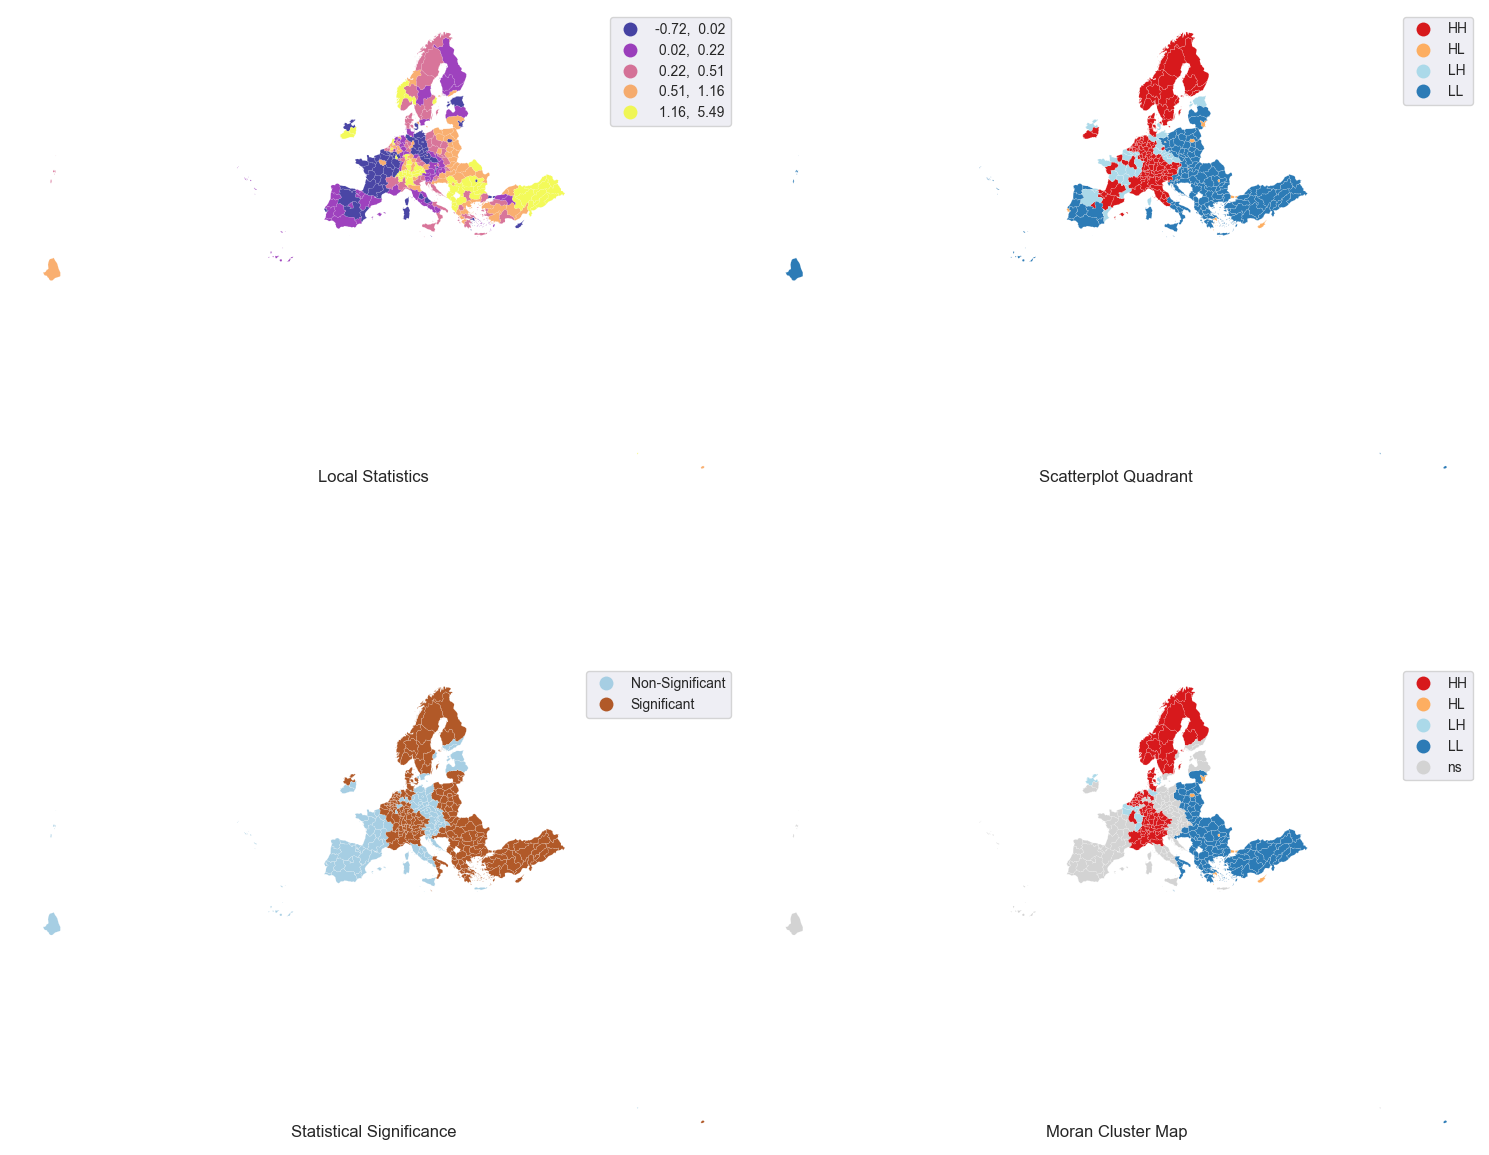

In [16]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
gdf_lvl2.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, gdf_lvl2, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=gdf_lvl2.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
gdf_lvl2.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)

# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdf_lvl2, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

# Adding lisa and significance column to df
numpy_df = pandas.DataFrame(lisa.Is, columns=['LISA_VALUE'])
gdf_lvl2['LISA_VALUE'] = numpy_df['LISA_VALUE']

series_df = labels.to_frame(name='LISA_sig')
gdf_lvl2['LISA_sig'] = series_df['LISA_sig']

# Get p-values from Local Moran's I
p_values = lisa.p_sim
# Create a DataFrame with the extracted p-values
p_values_df = pandas.DataFrame(p_values, columns=['LISA_p_values'])
gdf_lvl2['LISA_p_values'] = p_values_df['LISA_p_values']
# Get quadrant information from Local Moran's I
qd_df = pandas.DataFrame(lisa.q, columns=['LISA_quadrant'])
gdf_lvl2['LISA_quadrant'] = qd_df['LISA_quadrant']

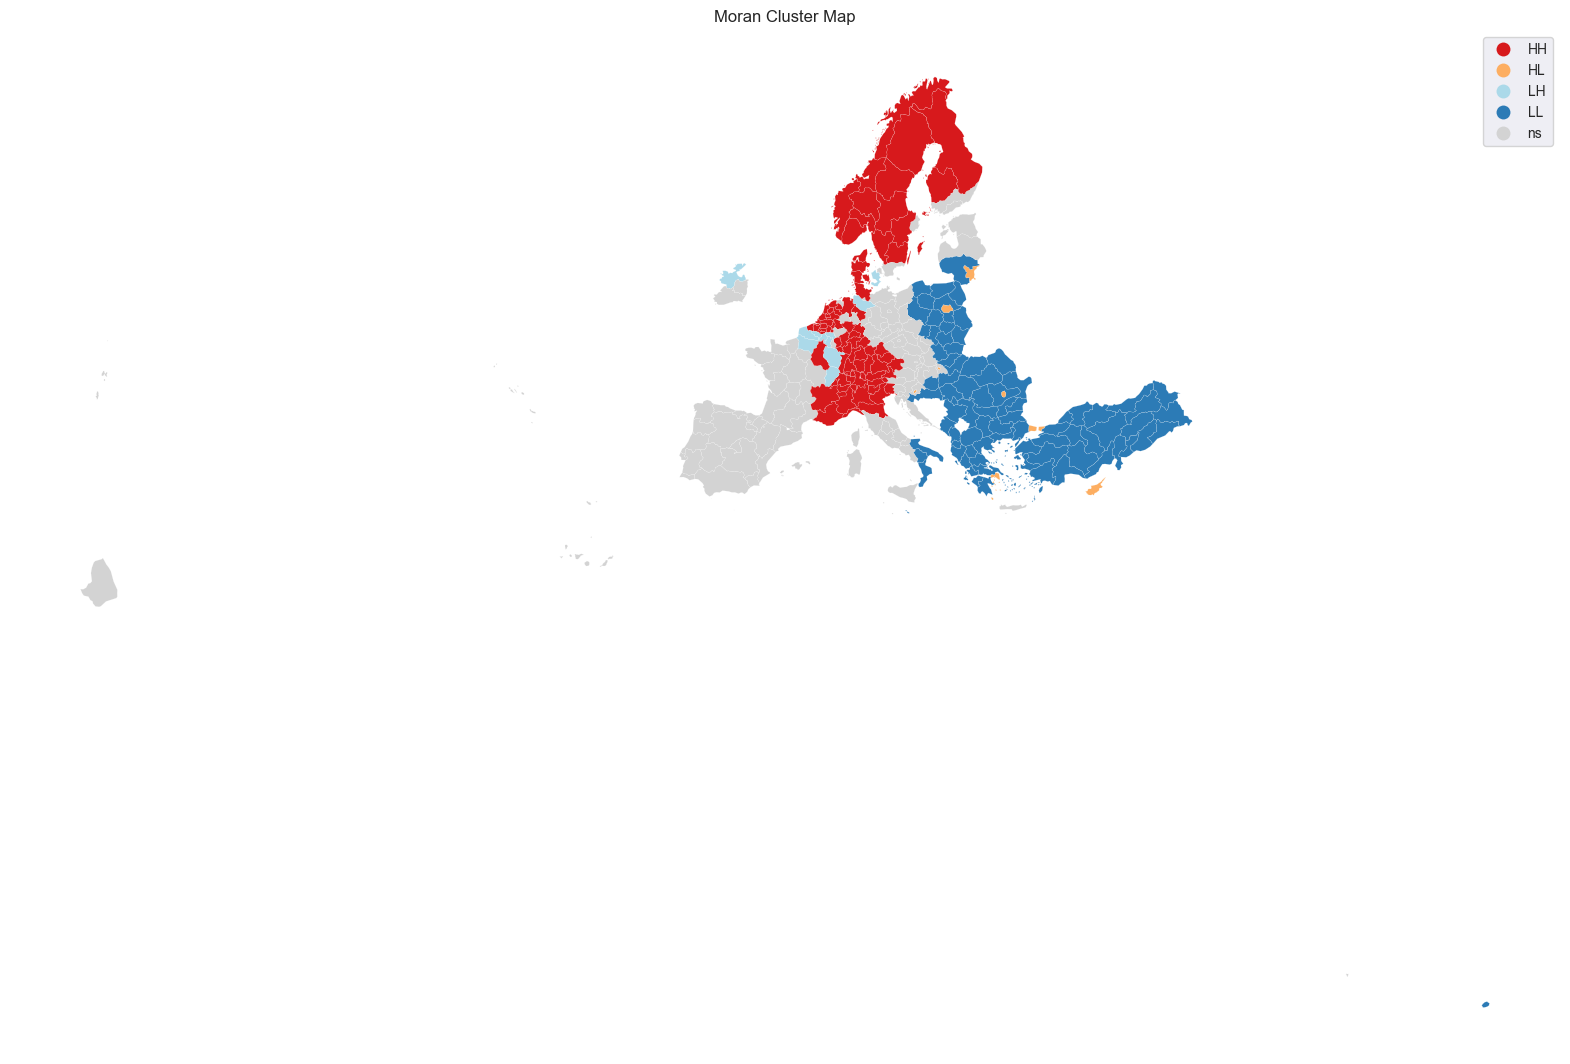

In [15]:
# Plot Quadrant colors with interactivity
fig, ax = plt.subplots(figsize=(20, 20))

# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant clusters
esdaplot.lisa_cluster(lisa, gdf_lvl2, p=0.05, ax=ax)
ax.set_title("Moran Cluster Map")

# Display the figure
plt.show()

### LH and HL regions

In [18]:
gdf_lvl2 = gdf_lvl2[gdf_lvl2['LISA_sig']=='Significant']
gdf_lvl2_LH = gdf_lvl2[gdf_lvl2['LISA_quadrant']==3]
gdf_lvl2_HL = gdf_lvl2[gdf_lvl2['LISA_quadrant']==4]
gdf_lvl2_HL

,NUTS_ID,NUTS_NAME,NAME_LATN,GDP_VALUE,geometry,centroid_lon,centroid_lat,centroid_geometry,LISA_VALUE,LISA_sig,LISA_p_values,LISA_quadrant
36,CY00,Κύπρος,Kýpros,24430.434783,"POLYGON ((6342668.882 1629618.498, 6342926.802...",6.426394e+06,1.653576e+06,POINT (6426393.676 1653575.741),-0.051325,Significant,0.001,4
89,EL30,Aττική,Attiki,27281.818182,"MULTIPOLYGON (((5571753.936 1641409.335, 55639...",5.520666e+06,1.742712e+06,POINT (5520665.998 1742711.892),-0.155801,Significant,0.014,4
155,HR05,Grad Zagreb,Grad Zagreb,28652.173913,"POLYGON ((4783286.155 2550595.060, 4798025.438...",4.788004e+06,2.540108e+06,POINT (4788004.258 2540107.715),-0.165405,Significant,0.034,4
157,HU11,Budapest,Budapest,35290.909091,"POLYGON ((4991721.704 2752702.184, 4991217.330...",5.006074e+06,2.750471e+06,POINT (5006074.277 2750470.876),-0.430164,Significant,0.008,4
189,LT01,Sostinės regionas,Sostinės regionas,25856.521739,"POLYGON ((5375053.128 3695401.144, 5372646.227...",5.292073e+06,3.626183e+06,POINT (5292072.698 3626182.842),-0.120404,Significant,0.005,4
229,PL91,Warszawski stołeczny,Warszawski stołeczny,35495.652174,"POLYGON ((5071981.878 3329177.882, 5093801.931...",5.077683e+06,3.294919e+06,POINT (5077682.562 3294918.960),-0.700539,Significant,0.001,4
243,RO32,Bucureşti-Ilfov,Bucureşti-Ilfov,31817.391304,"POLYGON ((5609779.075 2494714.091, 5599328.634...",5.595717e+06,2.516740e+06,POINT (5595717.363 2516740.490),-0.716151,Significant,0.001,4
264,TR10,İstanbul,İstanbul,26015.789474,"MULTIPOLYGON (((5940443.759 2176264.621, 59125...",5.883264e+06,2.203199e+06,POINT (5883263.914 2203198.552),-0.142801,Significant,0.001,4


In [19]:
gdf_lvl2_LH.to_csv("results/gdf_lvl2_LH.csv")
gdf_lvl2_HL.to_csv("results/gdf_lvl2_HL.csv")

# Relevant regions pairs (novel function)

In [17]:
lisa_df = gdf_lvl2.copy()

# converting NANs to float values in LISA_value and p-value column
lisa_df['LISA_VALUE'].fillna(0.0, inplace=True)
lisa_df['LISA_p_values'].fillna(0.0, inplace=True)

# Extracting neighbors for each region
neighbors = w_adaptive.neighbors

# Removing the region itself from its neighbors list
for key, neighbor_list in neighbors.items():
    neighbors[key] = [neighbor for neighbor in neighbor_list if neighbor != key]

# Identifying threshold to consider as positive local SAC or negative local SAC
pos_lisa = 0.5
neg_lisa = 0.0

def calculate_interesting_correlations(lisa_df, neighbors):
    # Initialize empty lists and dictionaries to store interesting correlation pairs
    global i_gdp
    No_SAC_dict = dict()
    negative_SAC_dict = dict()
    for region_i in neighbors:
        No_SAC = []
        negative_SAC = []
        for region_j in neighbors[region_i]:
            # store the significance of each region
            lisa_i_sig = lisa_df.loc[lisa_df['NUTS_ID'] == region_i, 'LISA_sig'].iloc[0]
            lisa_j_sig = lisa_df.loc[lisa_df['NUTS_ID'] == region_j, 'LISA_sig'].iloc[0]
            # store the lisa values of each region
            lisa_i = lisa_df.loc[lisa_df['NUTS_ID'] == region_i, 'LISA_VALUE'].iloc[0]
            lisa_j = lisa_df.loc[lisa_df['NUTS_ID'] == region_j, 'LISA_VALUE'].iloc[0]
            # store the gdp values of each region
            i_gdp = lisa_df.loc[lisa_df['NUTS_ID'] == region_i, 'GDP_VALUE'].iloc[0]
            j_gdp = lisa_df.loc[lisa_df['NUTS_ID'] == region_j, 'GDP_VALUE'].iloc[0]
            # Significant lisa scores for region i and j
            if lisa_i_sig == 'Significant' and lisa_j_sig == 'Significant':
                # Condition 1: region i or j has positive SAC while other has negative SAC
                if (lisa_i > pos_lisa and lisa_j < neg_lisa) or (lisa_i < neg_lisa and lisa_j > pos_lisa):
                    negative_SAC.append((region_j, j_gdp))
                # Condition 2: region i or region j has no SAC
                if lisa_i == 0.0 or lisa_j == 0.0:
                    No_SAC.append((region_j, j_gdp))
                # Condition 3 : both have positive SAC so then region not stored
            # Non-Significant lisa scores for region i and j
            elif lisa_i_sig == 'Non-Significant' and lisa_j_sig == 'Non-Significant':
                No_SAC.append((region_j, j_gdp))
        if len(No_SAC) > 0:
            No_SAC_dict[(region_i, i_gdp)] = No_SAC
        if len(negative_SAC) > 0:
            negative_SAC_dict[(region_i, i_gdp)] = negative_SAC
    return No_SAC_dict, negative_SAC_dict

In [ ]:
calculate_interesting_correlations(lisa_df, neighbors)[1]

# Average GDP across NUTS 2

In [20]:
# Center coordinates for the map
eu_center = [50.8503, 4.3517]

# Create a folium map centered on the EU center
m = folium.Map(location=eu_center, zoom_start=4)

# Add choropleth layer with GDP values
folium.Choropleth(
    geo_data=gdf_lvl2,
    data=gdf_lvl2,
    columns=['NUTS_ID', 'GDP_VALUE'],
    key_on='feature.properties.NUTS_ID',
    fill_color='OrRd',  # Color scale
    fill_opacity=0.7,
    line_opacity=0.1,
    legend_name='GDP Value',
    highlight=True,
    name='GDP Choropleth',
).add_to(m)

# Add GeoJSON layer with tooltip
folium.GeoJson(
    gdf_lvl2,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['NUTS_ID', 'GDP_VALUE'], labels=True, sticky=False)
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

TypeError: Object of type Point is not JSON serializable